In [17]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from mpl_toolkits import mplot3d

import scipy
from scipy.linalg import circulant

GPU = False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


In [2]:
circulant([1,2,3])

array([[1, 3, 2],
       [2, 1, 3],
       [3, 2, 1]])

In [3]:
def getX(d=5,n=10):
    x = np.random.randn(n)/np.sqrt(n)
    x = x - np.mean(x)
    X = circulant(x)
    for i in range(d-1):
        Wk = circulant(np.random.randn(n)/np.sqrt(n))
        X = np.dot( X , Wk )
    return X

def getGrad(X,y,w):
    return np.dot(X.T, y - np.dot(X,w) )

def getNGrad(X,y,w):
    Xw = np.dot(X,w)
    nor = np.linalg.norm(Xw)
    n = len(X)
    return np.dot(X.T , np.dot( (np.eye(n) - np.dot(Xw, Xw.T)/nor**2) , y)) / nor

## Distribution of gradient norms with and without normalization

In [4]:
def simulate(fun,n = 10,d = 6,numit = 1000):
    res = []
    for i in range(numit):
        X = getX(d=d,n=n)
        y = np.random.randn(n)
        w = np.random.randn(n)
        #print( np.linalg.norm(y)/np.linalg.norm( np.dot(X,w) ) )
        res += [np.linalg.norm(fun(X,y,w))]
    return res

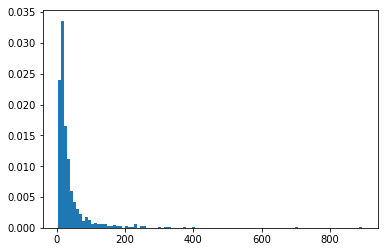

In [64]:
res_norm_dep6 = simulate(fun=getGrad,n=100,d=6,numit=1000)
fig1_dep6 = plt.hist(res_norm_dep6, normed=True, bins=100)
plt.show()

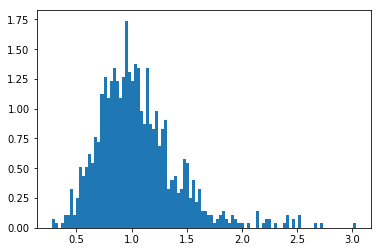

In [65]:
res_linear_dep6 = simulate(fun=getNGrad,n=100,d=6,numit=1000)
fig2_dep6 = plt.hist(res_linear_dep6, normed=True, bins=100)
plt.show()

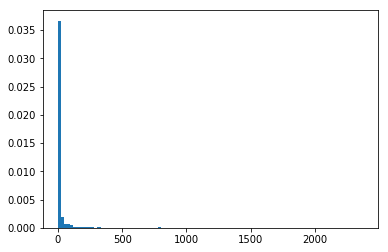

In [66]:
res_norm_dep20 = simulate(fun=getGrad,n=100,d=20,numit=1000)
fig1_dep20 = plt.hist(res_norm_dep20, normed=True, bins=100)
plt.show()

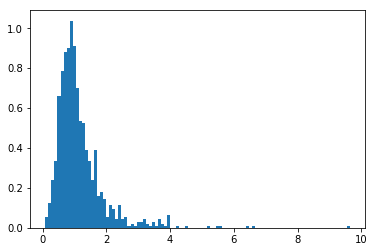

In [67]:
res_linear_dep20 = simulate(fun=getNGrad,n=100,d=20,numit=1000)
fig2_dep20 = plt.hist(res_linear_dep20, normed=True, bins=100)
plt.show()

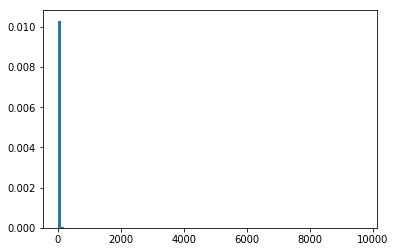

In [68]:
res_norm_dep40 = simulate(fun=getGrad,n=100,d=40,numit=1000)
fig1_dep40 = plt.hist(res_norm_dep40, normed=True, bins=100)
plt.show()

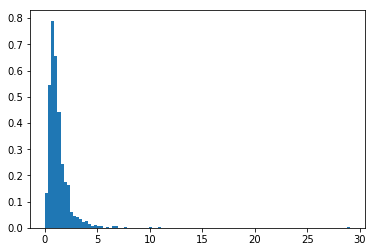

In [69]:
res_linear_dep40 = simulate(fun=getNGrad,n=100,d=40,numit=1000)
fig2_dep40 = plt.hist(res_linear_dep40, normed=True, bins=100)
plt.show()

In [111]:
## Distribution of gradient entries with and without normalization

In [102]:
def simulate_entries(fun,n = 10,d = 6,numit = 1000):
    res = []
    for i in range(numit):
        X = getX(d=d,n=n)
        y = np.random.randn(n)
        w = np.random.randn(n)
        res += [fun(X,y,w)]
    return np.array(res).flatten()

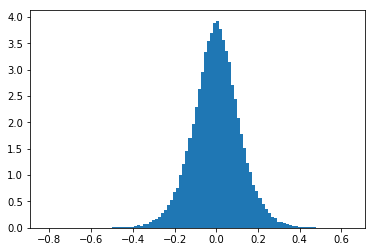

In [103]:
res = simulate_entries(fun=getNGrad,n=100,d=6,numit=1000)
plt.hist(res, normed=True, bins=100)
plt.show()

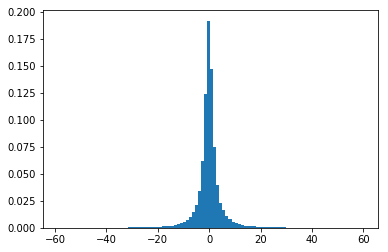

In [104]:
res = simulate_entries(fun=getGrad,n=100,d=6,numit=1000)
plt.hist(res, normed=True, bins=100)
plt.show()

## Distribution of Gradient Norm for Deep Decoder

In [10]:
def grad_eval(net, y, net_input, LR = 0.05):
    p = [x for x in net.parameters()]
    optimizer = torch.optim.SGD(p, lr=LR,momentum=0)
    mse = torch.nn.MSELoss()

    nconvnets = 0
    for p in list(filter(lambda p: p.data.shape[0]>2, net.parameters())):
        nconvnets += 1
    optimizer.zero_grad()
    out = net(net_input.type(dtype))

    # training loss 
    loss = mse(out, img_var)
    loss.backward()
    mse_wrt_noisy = loss.data.cpu().numpy()

    # output gradients
    out_grads = np.zeros(nconvnets)
    for ind,p in enumerate(list(filter(lambda p: p.grad is not None and p.data.shape[0]>2, net.parameters()))):
        # print(p.shape)
        out_grads[ind] = p.grad.data.norm(2).item()**2

    overall_grads = np.sqrt(sum(out_grads))
    return overall_grads 

In [18]:
def rep_error_deep_decoder(img_np,net,net_input,convert2ycbcr=False):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    output_depth = img_np.shape[0]
    if output_depth == 3 and convert2ycbcr:
        img = rgb2ycbcr(img_np)
    else:
        img = img_np
    img_var = np_to_var(img).type(dtype)
    
    rnd = 500
    numit = 2500
    rn = 0.005
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        net_input=net_input.type(dtype),        
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        #LR=0.005,
                        LR=0.05,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=False,
                        OPTIMIZER='SGD',
                               )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    if output_depth == 3 and convert2ycbcr:
        out_img = ycbcr2rgb(out_img)
    return psnr(out_img,img_np), out_img, num_param(net)


def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')    
        
    
    
def apply_until(net_input,net,n = 100):
    # applies function by funtion of a network
    for i,fun in enumerate(net):
        if i>=n:
            break
        if i==0:
            out = fun(net_input.type(dtype))
        else:
            out = fun(out)
    print(i, "last func. applied:", net[i-1])
    if n == 0:
        return net_input
    else:
        return out



class ChannelNormalization(torch.nn.Module):
    def __init__(self, D_in,mode="BN"):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        self.mode = mode
        requires_grad=True
        super(ChannelNormalization, self).__init__()
        #self.gamma = Variable(torch.ones(D_in),requires_grad=requires_grad).type(dtype)
        #self.beta = Variable(torch.zeros(D_in),requires_grad=requires_grad).type(dtype)
        #self.gamma = nn.Parameter(torch.ones(D_in),requires_grad=requires_grad).type(dtype)
        #self.beta = nn.Parameter(torch.zeros(D_in),requires_grad=requires_grad).type(dtype)
        
        self.gamma = nn.Parameter(torch.ones(D_in))
        self.beta = nn.Parameter(torch.zeros(D_in))

        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        
        xx = Variable(torch.zeros(x.shape)).type(dtype)
        for i,(g,b) in enumerate(zip(self.gamma,self.beta)):
            #print(i, x[0][i].shape)
            if self.mode == "BN":
                #xx[:,i] = (x[:,i] - torch.mean(x[:,i]))/(torch.std(x[:,i]) + 0.00000001 ) *g + b
                #print(torch.mean(x[0][i]))
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g + b
                #xx[0][i] = (x[0][i] - torch.mean(x[0]))/(torch.std(x[0]) + 0.00000001 ) *g + b
            elif self.mode == "mult":
                xx[:,i] = x[:,i]*g + b
            elif self.mode == "non-learned":
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 )
            elif self.mode == "center":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "none":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "normalize+bias":
                xx[0][i] = (x[0][i])/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g + b
            elif self.mode == "only+bias":
                xx[:,i] = x[:,i] + b
            elif self.mode == "onlycenter+bias":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))*g + b
            elif self.mode == "almostcenter":
                xx[:,i] = ( (x[:,i] - torch.mean(x[:,i])) + torch.mean(x[:,i]) / torch.from_numpy( np.sqrt( np.array([np.prod(x[0][i].shape)]) ) ).float().type(dtype)) /torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "center+scale":
                #xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( x[:,i] - torch.mean(x[:,i]) )  - torch.min( x[:,i] - torch.mean(x[:,i]) ) )
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( torch.abs(x[:,i] - torch.mean(x[:,i]) ) ) + 0.00001)
            elif self.mode == "center+mean_scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / torch.mean(torch.abs( x[:,i] - torch.mean(x[:,i]) ) )
            elif self.mode == "noise":
                #   noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
                #no = torch.norm(x[0][i].data)
                #sigma = 0.1*no
                #noise = Variable( torch.randn( x[0][i].size() ) * sigma ).type(dtype)
                #noise = Variable( x[0][i].data.new(x[0][i].size()).normal_(0, sigma))
                xx[0][i] = x[0][i] / ( torch.norm(x[0][i])* np.prod(x[0][i].shape) + 0.00001  ) + b
                #xx[0][i] = x[0][i] / torch.norm( x[0][i] )  + noise + b
                #xx[0][i] = (x[0][i] - torch.mean(x[0][i])) / torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            #elif self.mode == "center_then_normalize": # stupid; is the same as BN
            #    center =  (x[0][i] - torch.mean(x[0][i]))
            #    xx[0][i] = center / torch.sqrt( torch.var(center) + 0.00001 ) + b
            elif self.mode == "scale":
                z =  x[0][i]
                xx[0][i] = z / ( torch.norm(z) + 0.00001 )*g + b
            else:
                raise ValueError('not an option for channel normalization.')


        #x = x*self.gamma[0] + self.beta[0]
        return xx
    

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.xavier_uniform(m.weight)

def conv(in_f, out_f, kernel_size, stride=1, pad='zero',bias=False):
    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)

    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers)


class normalizedconv(nn.Module):
    def __init__(self,in_f, out_f, kernel_size, stride, pad, bias):
        super(normalizedconv, self).__init__()
        self.conv = conv(in_f, out_f, kernel_size, stride, pad, bias)
    def forward(self,x):
        xx = self.conv(x)
        nchannels = self.conv[1].weight.shape[0]
        for i in range(nchannels):
            xx[:,i] /= torch.norm( self.conv[1].weight[i],p=2 )
        return xx

#          self.conv1.weight /=torch.norm(self.conv1.weight, p=2, 1,keepdim=True)
#          output = self.conv1(input)

def decnet(
        num_output_channels=3, 
        num_channels_up=[128]*5, 
        filter_size_up=1,
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        mode = "none",
        upsample = False,
        nonlin = False,
        ):
    
    num_channels_up = num_channels_up + [num_channels_up[-1]]
    n_scales = len(num_channels_up) 
    
    model = nn.Sequential()

    # print("generated net with mode ", mode)
    for i in range(len(num_channels_up)-1):
        if mode=="channeln":
            model.add(normalizedconv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1, pad='reflection',bias=False))        
        else:
            model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1, pad='reflection',bias=False))        

        if nonlin:
            model.add(act_fun)
        #model.add(nn.BatchNorm2d( num_channels_up[i+1] ,affine=True))
        if mode!= "channeln":
            model.add(ChannelNormalization(num_channels_up[i+1],mode=mode))
        #model.add(nn.BatchNorm2d( num_channels_up[i+1] ,affine=True,track_running_stats=False,momentum=0))                 
        if upsample:
            model.add(nn.Upsample(scale_factor=2, mode="bilinear"))
    
    model.add(conv( num_channels_up[-1], num_output_channels, 1, pad='reflection',bias=True))
    model.add(nn.Sigmoid())
    
    return model

In [32]:
path = './test_data/'
img_name = "phantom256"
img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_np = img_np[:,0:64,0:64]
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)
print(img_var.shape)

torch.Size([1, 1, 64, 64])


#### Channel Normalization with fixed scaling and shift

In [60]:
num_channels = [16]*5
output_depth = 1

totalupsample = 2**len(num_channels)
width = int(img_var.data.shape[2]/totalupsample)
height = int(img_var.data.shape[3]/totalupsample)

num_iter = 1000
para_grad_norm = np.zeros(num_iter)

for i in range(num_iter):
    shape = [1,num_channels[0], width,height]
    # print("shape: ", shape)
    net_input = Variable(torch.zeros(shape))
    net_input.data.uniform_()
    net_input.data *= 1./10

    output_depth = img_np.shape[0] # number of output channels
    net = decnet(output_depth,num_channels,filter_size_up=1,mode="non-learned",upsample=True,nonlin = True).type(dtype)
    net.apply(init_normal)

    para_grad_norm[i] = grad_eval(net, y=img_var, net_input=net_input)

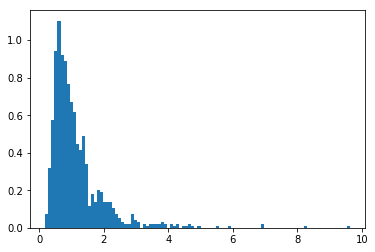

In [61]:
fig3 = plt.hist(para_grad_norm, normed=True, bins=100)
plt.show()

#### No Channel Normalization

In [62]:
num_channels = [16]*5
output_depth = 1

totalupsample = 2**len(num_channels)
width = int(img_var.data.shape[2]/totalupsample)
height = int(img_var.data.shape[3]/totalupsample)

num_iter = 1000
para_grad_linear = np.zeros(num_iter)

for i in range(num_iter):
    shape = [1,num_channels[0], width,height]
    # print("shape: ", shape)
    net_input = Variable(torch.zeros(shape))
    net_input.data.uniform_()
    net_input.data *= 1./10

    output_depth = img_np.shape[0] # number of output channels
    net = decnet(output_depth,num_channels,filter_size_up=1,mode="none",upsample=True,nonlin = True).type(dtype)
    net.apply(init_normal)

    para_grad_linear[i] = grad_eval(net, y=img_var, net_input=net_input)

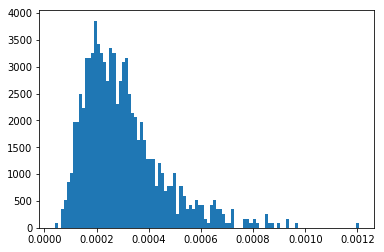

In [63]:
fig4 = plt.hist(para_grad_linear, normed=True, bins=100)
plt.show()

## Combine the figures

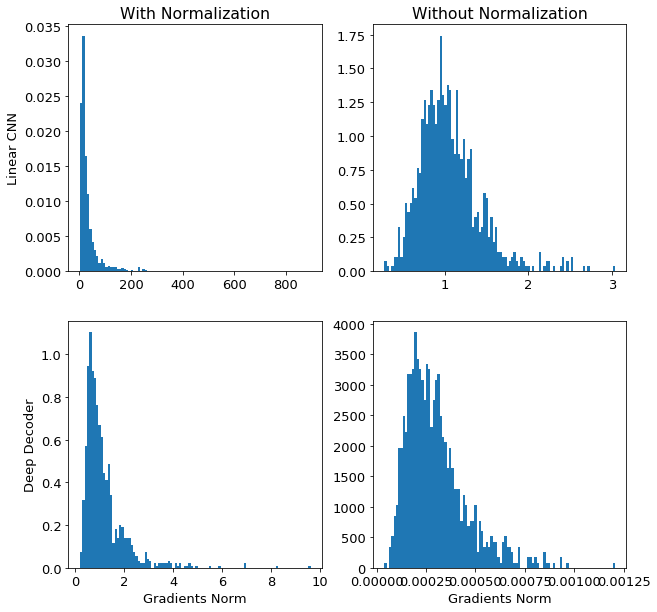

In [82]:
from matplotlib import gridspec
plt.rcParams.update({'font.size': 13})

fig = plt.figure(figsize = (10,10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.hist(res_norm_dep6, normed=True, bins=100)
# ax0.set_xlabel('Gradients Norm')
ax0.set_ylabel('Linear CNN')
ax0.set_title('With Normalization')

ax1 = plt.subplot(gs[1])
ax1.hist(res_linear_dep6, normed=True, bins=100)
# ax1.set_xlabel('Gradients Norm')
ax1.set_title('Without Normalization')

ax2 = plt.subplot(gs[2])
ax2.hist(para_grad_norm, normed=True, bins=100)
ax2.set_xlabel('Gradients Norm')
ax2.set_ylabel('Deep Decoder')

ax3 = plt.subplot(gs[3])
ax3.hist(para_grad_linear, normed=True, bins=100)
ax3.set_xlabel('Gradients Norm')

fig.savefig('C:/Reinhard Research Projects/ICLR workshop/Figure/Distribution of Gradient Norm.pdf')